data is getting from [link](https://www.kaggle.com/code/aneesh10/ner-with-pytorch-and-bert)

- This is a POC of using the BERT NER model
- The label was already labeled using 'IOB2' format

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn import model_selection, preprocessing
import matplotlib.pyplot as plt
from collections import defaultdict

import datasets
import torch
from torch.nn.functional import cross_entropy
from datasets import Dataset, DatasetDict
import transformers
from transformers import (
    TrainingArguments, 
    Trainer,
    AutoTokenizer, 
    AutoConfig,
    AutoModelForTokenClassification, 
    DataCollatorForTokenClassification, 
    set_seed
)

c:\Users\dong\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
## constants for this notebook
config = {
    'model_name': "bert-base-cased",
    'ner_model_output': './results/tuned_ner/',
    'num_epochs': 3,
    'batch_size': 16,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv('./data/ner_dataset.csv', encoding='latin-1')
# in this demo code, I removed some rare labels
def remove_rare_label(label):
    if label!='O' and ('geo' not in label) and\
          ('tim' not in label) and ('org' not in label) and\
              ('per' not in label):
        label = 'O'
    return label
df['Tag'] = df['Tag'].apply(lambda x: remove_rare_label(x))

# fill na's by using forward not null
df['Sentence #'] = df['Sentence #'].fillna(method='ffill')

# create label2idx match
tag_encoder = preprocessing.LabelEncoder()
df['Tag_ids'] = tag_encoder.fit_transform(df['Tag'])

# show some samples of the data
pd.concat([df.head(10), df.tail(10)])

,Sentence #,Word,POS,Tag,Tag_ids
0,Sentence: 1,Thousands,NNS,O,8
1,Sentence: 1,of,IN,O,8
2,Sentence: 1,demonstrators,NNS,O,8
3,Sentence: 1,have,VBP,O,8
4,Sentence: 1,marched,VBN,O,8
5,Sentence: 1,through,IN,O,8
6,Sentence: 1,London,NNP,B-geo,0
7,Sentence: 1,to,TO,O,8
8,Sentence: 1,protest,VB,O,8
9,Sentence: 1,the,DT,O,8


In [4]:
df['Tag'].value_counts()

O        905488
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
I-geo      7414
I-tim      6528
Name: Tag, dtype: int64

### group the words and its tags

In [5]:
# get list form of datasets
sentences = df.groupby('Sentence #')['Word'].apply(list).values
tags = df.groupby('Sentence #')['Tag_ids'].apply(list).values

In [6]:
# split the data into train, validation and test datasets
train_sentence, val_sentences, train_tags, val_tags = \
model_selection.train_test_split(sentences, tags, test_size=0.3, random_state=42)

val_sentence, test_sentence, val_tags, test_tags = \
model_selection.train_test_split(val_sentences, val_tags, test_size=0.5, random_state=42)

In [7]:
# ner tage
# create datsetdic for transformers model
ds = DatasetDict({
    "train": Dataset.from_dict({
        'tokens': train_sentence,
        'ner_tags': train_tags,
    }),
    "validation": Dataset.from_dict({
        'tokens': val_sentence,
        'ner_tags': val_tags,
    }),
    "test": Dataset.from_dict({
        'tokens': test_sentence,
        'ner_tags': test_tags,
    }),
})

### import models

In [8]:
model_tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

model_config = AutoConfig.from_pretrained(
    config['model_name'], 
    num_labels=len(tag_encoder.classes_)
)

### tokenizing the texts for NER

In [9]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = model_tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True
    )
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

def encode_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, 
                      remove_columns=['ner_tags', 'tokens'])

In [10]:
ds_encoded = encode_dataset(ds)

  0%|          | 0/34 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

### Performance Measures

In [11]:
metric = datasets.load_metric("seqeval")
# import evaluate
# metric = evaluate.load_metric("seqeval")

def compute_metrics(p):
    if isinstance(p, transformers.trainer_utils.EvalPrediction):
        predictions, labels = p.predictions, p.label_ids
        predictions = np.argmax(predictions, axis=2)
    else: # if input is dict(list), for evaluation purpose
        predictions, labels = p['predictions'], p['label_ids']

    # Remove ignored index (special tokens)
    true_predictions = [
        [tag_encoder.classes_[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [tag_encoder.classes_[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

<ipython-input-11-3a22c5a8456c>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric("seqeval")


### Fine-Tuning Bert model

In [12]:
logging_steps = len(ds_encoded["train"]) // config['batch_size']
training_args = TrainingArguments(
    output_dir=config['ner_model_output'], 
    log_level="error", 
    num_train_epochs=config['num_epochs'], 
    per_device_train_batch_size=config['batch_size'], 
    per_device_eval_batch_size=config['batch_size'], 
    evaluation_strategy="epoch", 
    save_steps=1e6, 
    weight_decay=0.01, 
    disable_tqdm=False, 
    logging_steps=logging_steps, 
    push_to_hub=False
)

data_collator = DataCollatorForTokenClassification(model_tokenizer)

def model_init():
    return (AutoModelForTokenClassification
            .from_pretrained(config['model_name'], config=model_config)
            .to(device))

In [13]:
trainer = Trainer(
    model_init=model_init, 
    args=training_args, 
    data_collator=data_collator, 
    compute_metrics=compute_metrics,
    train_dataset=ds_encoded["train"],
    eval_dataset=ds_encoded["validation"], 
    tokenizer=model_tokenizer
)

In [14]:
# train the model
trainer.train()
# save the model
trainer.save_model(config['ner_model_output'])

  0%|          | 0/6297 [00:00<?, ?it/s]

{'loss': 0.1097, 'learning_rate': 3.3341273622359855e-05, 'epoch': 1.0}


  0%|          | 0/450 [00:00<?, ?it/s]

{'eval_loss': 0.08226210623979568, 'eval_precision': 0.8169649049798863, 'eval_recall': 0.8269446784611064, 'eval_f1': 0.8219244993371014, 'eval_accuracy': 0.9729118055821189, 'eval_runtime': 13.7324, 'eval_samples_per_second': 523.87, 'eval_steps_per_second': 32.769, 'epoch': 1.0}
{'loss': 0.0658, 'learning_rate': 1.668254724471971e-05, 'epoch': 2.0}


  0%|          | 0/450 [00:00<?, ?it/s]

{'eval_loss': 0.076265849173069, 'eval_precision': 0.8265573318632855, 'eval_recall': 0.8421089581578208, 'eval_f1': 0.834260676032828, 'eval_accuracy': 0.975053870379579, 'eval_runtime': 13.7684, 'eval_samples_per_second': 522.502, 'eval_steps_per_second': 32.684, 'epoch': 2.0}
{'loss': 0.0414, 'learning_rate': 2.3820867079561695e-08, 'epoch': 3.0}


  0%|          | 0/450 [00:00<?, ?it/s]

{'eval_loss': 0.08396338671445847, 'eval_precision': 0.8319131390874107, 'eval_recall': 0.8499017130019657, 'eval_f1': 0.8408112237810806, 'eval_accuracy': 0.9754810083005011, 'eval_runtime': 14.0736, 'eval_samples_per_second': 511.171, 'eval_steps_per_second': 31.975, 'epoch': 3.0}
{'train_runtime': 597.6461, 'train_samples_per_second': 168.516, 'train_steps_per_second': 10.536, 'train_loss': 0.07230833517581257, 'epoch': 3.0}


In [15]:
final_results = trainer.predict(ds_encoded["test"])
# print('f1 score is {:.4f}'.format(final_results.metrics["test_f1"]))
final_results.metrics

  0%|          | 0/450 [00:00<?, ?it/s]

{'test_loss': 0.08502498269081116,
 'test_precision': 0.8233532934131736,
 'test_recall': 0.8414464534075105,
 'test_f1': 0.8323015545467052,
 'test_accuracy': 0.9746865238661738,
 'test_runtime': 14.0426,
 'test_samples_per_second': 512.298,
 'test_steps_per_second': 32.045}

In [16]:
# show the logs of the training process
df_log = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1']]
df_log = df_log.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
df_log['Epoch'] = df_log["Epoch"].apply(lambda x: round(x))
df_log['Training Loss'] = df_log["Training Loss"].ffill()
df_log[['Validation Loss', 'F1']] = df_log[['Validation Loss', 'F1']].bfill().ffill()
df_log.drop_duplicates()

,Epoch,Training Loss,Validation Loss,F1
0,1,0.1097,0.082262,0.821924
2,2,0.0658,0.076266,0.834261
4,3,0.0414,0.083963,0.840811


### Error analysis

In [17]:
# load the model
test_model = AutoModelForTokenClassification.from_pretrained(config['ner_model_output']).to(device)

# arguments for Trainer
test_args = TrainingArguments(
    output_dir = config['ner_model_output'],
    do_train = False,
    do_predict = True,
    per_device_eval_batch_size = 1,   
    dataloader_drop_last = False    
)

# init trainer
test_trainer = Trainer(model = test_model, args = test_args, compute_metrics = compute_metrics)

In [18]:
def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model  
        output = test_trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, len(tag_encoder.classes_)), 
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [19]:
test_set = ds_encoded["test"]
test_set = test_set.map(forward_pass_with_label, batched=True, batch_size=config['batch_size'])
df_test = test_set.to_pandas()
df_test.head(1)

Parameter 'function'=<function forward_pass_with_label at 0x000001F53B0814C0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/450 [00:00<?, ?ba/s]

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label
0,"[101, 1622, 1516, 1106, 1384, 117, 1103, 4190,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 3, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0.0, 0.14453547, 0.055064756, 0.027345747, 0....","[8, 3, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."


In [20]:
# same metric results as earlier
# successfully loaded the model
compute_metrics({
    'predictions':df_test['predicted_label'].to_list(),
    'label_ids':df_test['labels'].to_list()
})

{'precision': 0.8233532934131736,
 'recall': 0.8414464534075105,
 'f1': 0.8323015545467052,
 'accuracy': 0.9746865238661738}

In [21]:
# generate outputs
df_test["input_tokens"] = df_test["input_ids"].apply(
    lambda x: model_tokenizer.convert_ids_to_tokens(x))
df_test["predicted_label"] = df_test["predicted_label"].apply(
    lambda x: [tag_encoder.inverse_transform([i])[0] for i in x])
df_test["labels"] = df_test["labels"].apply(
    lambda x: [tag_encoder.inverse_transform([i])[0] if i>=0 else 'IGN' for i in x])
df_test['loss'] = df_test.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df_test['predicted_label'] = df_test.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df_test.head(1)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[101, 1622, 1516, 1106, 1384, 117, 1103, 4190,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, B-tim, I-tim, I-tim, I-tim, O, O, O, O, ...","[0.0, 0.14453547, 0.055064756, 0.027345747, 0....","[O, B-tim, I-tim, I-tim, I-tim, O, O, O, O, O,...","[[CLS], From, 2004, to, 2007, ,, the, economy,..."


In [22]:
df_tokens = df_test.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'") # remove ignore
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,1622,0,1,B-tim,0.14,B-tim,From
0,1516,0,1,I-tim,0.06,I-tim,2004
0,1106,0,1,I-tim,0.03,I-tim,to
0,1384,0,1,I-tim,0.01,I-tim,2007
0,117,0,1,O,0.00,O,","
0,1103,0,1,O,0.00,O,the
0,4190,0,1,O,0.00,O,economy


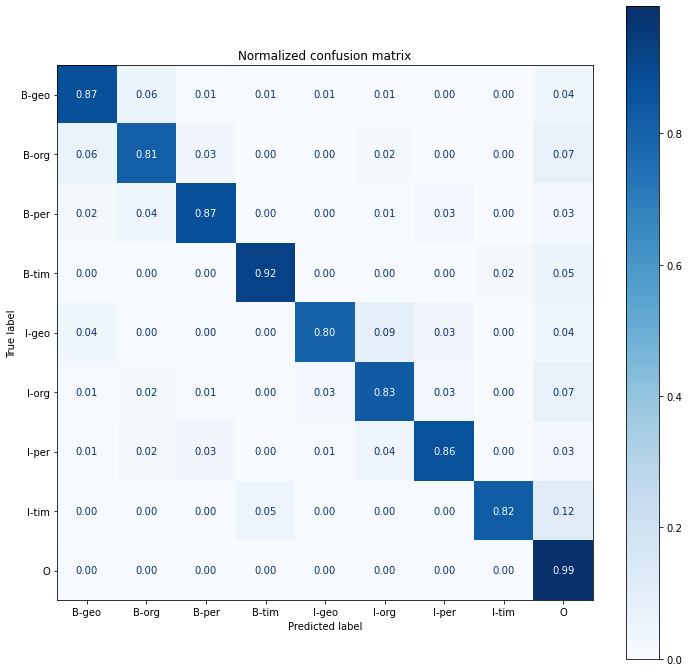

In [23]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(12, 12))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      list(tag_encoder.classes_))